In [5]:
import sys
import os

import gcsfs
import numpy as np
import pandas as pd
import wandb
from catboost import CatBoostClassifier, Pool
from numpy.testing import assert_almost_equal
from pandas._testing.asserters import assert_almost_equal
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict
from tqdm.notebook import tqdm

sys.path.append("..")

In [23]:
# connect to weights and biases
run = wandb.init(project="thesis", job_type="dataset-creation", entity="fbv")
dataset = wandb.Artifact(name="train_val_test_ultra", type="preprocessed_data")


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: karelze (fbv). Use `wandb login --relogin` to force relogin
2023-01-23 10:44:49.791228: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2023-01-23 10:44:56.279157: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
os.environ["GCLOUD_PROJECT"] = "flowing-mantis-239216"

fs = gcsfs.GCSFileSystem(project="thesis")

/home/kit/stud/uloak/.local/lib/python3.8/site-packages/google/auth/_default.py:83: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [5]:
files = [f"gs://thesis-bucket-option-trade-classification/data/preprocessed/matched_ise_quotes_min_mem_usage_extended_part_{i:04d}.parquet" for i in range(0, 50)]

asks = [f"ASK_{i}" for i in range(1, 17)]
bids = [f"BID_{i}" for i in range(1, 17)]

columns = [
    "QUOTE_DATETIME",
    "ROOT",
    "EXPIRATION",
    "STRK_PRC",
    "OPTION_TYPE",
    "TRADE_SIZE",
    "TRADE_PRICE",
    "BEST_BID",
    "BEST_ASK",
    "ask_ex",
    "bid_ex",
    "bid_size_ex",
    "ask_size_ex",
    "price_all_lead",
    "price_all_lag",
    "optionid",
    "day_vol",
    "price_ex_lead",
    "price_ex_lag",
    "issue_type",
    "myn",
    *asks,
    *bids,
    "buy_sell",
]

dfs = [pd.read_parquet(gc_file, columns=columns) for gc_file in tqdm(files)]
df = pd.concat(dfs)

del dfs

  0%|          | 0/50 [00:00<?, ?it/s]

/home/kit/stud/uloak/.local/lib/python3.8/site-packages/google/auth/_default.py:83: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [6]:
df.memory_usage(deep=True).sum()


16340145917

In [7]:
df.head().T


,0,1,2,3,4
QUOTE_DATETIME,2005-05-02 09:30:02,2005-05-02 09:30:03,2005-05-02 09:30:03,2005-05-02 09:30:03,2005-05-02 09:30:03
ROOT,YNU,SYQ,SWG,QAX,ORQ
EXPIRATION,2006-01-21 00:00:00,2005-06-18 00:00:00,2005-05-21 00:00:00,2005-06-18 00:00:00,2005-12-17 00:00:00
STRK_PRC,2.5,15.0,105.0,25.0,14.0
OPTION_TYPE,C,C,C,C,C
TRADE_SIZE,10,10,50,10,15
TRADE_PRICE,2.05,3.9,11.2,0.2,0.25
BEST_BID,1.9,3.6,11.1,0.0,0.3
BEST_ASK,2.1,3.8,11.4,0.25,0.4
ask_ex,2.1,NaN,11.4,0.25,0.45


In [10]:
# check against some stats from sub panel A.1 in Grauer et al

# trade size
stats_trade_size = df["TRADE_SIZE"].agg(["mean", "median", "std"])

assert_almost_equal(stats_trade_size.values.tolist(), [13.62, 4.0, 77.75], atol=0.1)

# time to maturity
stats_time_to_maturity = (df["EXPIRATION"] - df["QUOTE_DATETIME"]).dt.days
stats_time_to_maturity = stats_time_to_maturity.agg(["mean", "median", "std"])

# no of observations
stats_n = len(df)
assert stats_n == 49203747

# trade_size = quote size; TRADE_SIZE
stats_trades_with_quote_size_bid = df["bid_size_ex"].eq(df["TRADE_SIZE"])
stats_trades_with_quote_size_ask = df["ask_size_ex"].eq(df["TRADE_SIZE"])

# ask or bid 
stats_trade_with_quote_size = (
    stats_trades_with_quote_size_bid | stats_trades_with_quote_size_ask
).sum() / stats_n
assert_almost_equal(stats_trade_with_quote_size, 0.2281, atol=0.01)

# no of buys
stats_buy_trades = df["buy_sell"].ge(0).sum() / stats_n
assert_almost_equal(stats_buy_trades, 0.4746, atol=0.01)


## train-test-split ⚗️

In [11]:
train = df[df.QUOTE_DATETIME.between("2005-05-02 00:00:01", "2013-10-24 23:59:00")]

len_train = len(train)
print(f"train ratio: {len_train / len(df)}")


train ratio: 0.5997575753732739


In [15]:
val = df[df.QUOTE_DATETIME.between("2013-10-25 00:00:01", "2015-11-05 23:59:00")]
len_val = len(val)
print(f"train ratio: {len_val / len(df)}")


train ratio: 0.1998191519845023


In [19]:
test = df[df.QUOTE_DATETIME.between("2015-11-06 00:00:01", "2017-05-31 23:59:00")]
len_test = len(test)
print(f"train ratio: {len_test / len(df)}")


train ratio: 0.20042327264222376


In [20]:
# check if total is sum of its parts
assert len_train + len_val + len_test == len(df)


In [13]:
train


,QUOTE_DATETIME,ROOT,EXPIRATION,STRK_PRC,OPTION_TYPE,TRADE_SIZE,TRADE_PRICE,BEST_BID,BEST_ASK,ask_ex,...,BID_8,BID_9,BID_10,BID_11,BID_12,BID_13,BID_14,BID_15,BID_16,buy_sell
0,2005-05-02 09:30:02,YNU,2006-01-21,2.5,C,10,2.05,1.90,2.10,2.10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,2005-05-02 09:30:03,SYQ,2005-06-18,15.0,C,10,3.90,3.60,3.80,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,2005-05-02 09:30:03,SWG,2005-05-21,105.0,C,50,11.20,11.10,11.40,11.40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
3,2005-05-02 09:30:03,QAX,2005-06-18,25.0,C,10,0.20,0.00,0.25,0.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,2005-05-02 09:30:03,ORQ,2005-12-17,14.0,C,15,0.25,0.30,0.40,0.45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29510315,2013-10-24 16:13:41,IWM,2013-11-08,106.0,P,43,0.15,0.15,0.17,0.19,...,0.15,0.10,0.15,0.15,0.00,NaN,NaN,NaN,NaN,-1
29510316,2013-10-24 16:13:52,XLE,2014-01-18,77.0,P,1,0.60,0.56,0.60,0.60,...,0.50,0.50,0.52,0.50,0.51,NaN,NaN,NaN,NaN,1
29510317,2013-10-24 16:13:52,XLE,2014-01-18,71.0,P,1,0.23,0.21,0.26,0.26,...,0.18,0.21,0.21,0.21,0.16,NaN,NaN,NaN,NaN,-1
29510318,2013-10-24 16:14:33,IWM,2013-11-08,106.0,P,31,0.16,0.16,0.19,0.20,...,0.16,0.15,0.15,0.16,0.16,NaN,NaN,NaN,NaN,-1


In [16]:
val


,QUOTE_DATETIME,ROOT,EXPIRATION,STRK_PRC,OPTION_TYPE,TRADE_SIZE,TRADE_PRICE,BEST_BID,BEST_ASK,ask_ex,...,BID_8,BID_9,BID_10,BID_11,BID_12,BID_13,BID_14,BID_15,BID_16,buy_sell
29510320,2013-10-25 09:30:00,IWM,2014-03-31,97.0,P,20,1.47,1.38,1.62,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
29510321,2013-10-25 09:30:00,IWM,2014-09-30,105.0,P,20,6.27,5.85,6.31,6.31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
29510322,2013-10-25 09:30:00,UNG,2013-12-21,18.0,C,2,1.32,1.19,1.44,1.44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
29510323,2013-10-25 09:30:00,VXX,2013-10-25,14.5,P,20,1.66,1.62,1.70,1.70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
29510324,2013-10-25 09:30:00,GRPN,2013-10-25,10.5,P,1,0.85,0.00,0.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39342166,2015-11-05 16:14:37,UVXY,2015-11-06,27.0,C,1,0.88,0.86,0.96,0.96,...,0.86,0.86,0.86,0.00,0.48,NaN,NaN,NaN,NaN,-1
39342167,2015-11-05 16:14:40,QQQ,2015-12-18,109.0,C,2,6.59,6.51,6.68,6.68,...,6.51,6.51,6.51,6.51,5.73,NaN,NaN,NaN,NaN,-1
39342168,2015-11-05 16:14:53,SPY,2015-12-24,220.0,P,1,11.42,11.08,11.60,11.60,...,10.04,9.23,9.52,9.52,10.04,NaN,NaN,NaN,NaN,1
39342169,2015-11-05 16:14:53,SPY,2015-12-24,220.0,P,1,11.41,11.08,11.60,11.60,...,10.04,9.23,9.52,9.52,10.04,NaN,NaN,NaN,NaN,1


In [21]:
test


,QUOTE_DATETIME,ROOT,EXPIRATION,STRK_PRC,OPTION_TYPE,TRADE_SIZE,TRADE_PRICE,BEST_BID,BEST_ASK,ask_ex,...,BID_8,BID_9,BID_10,BID_11,BID_12,BID_13,BID_14,BID_15,BID_16,buy_sell
39342171,2015-11-06 09:30:00,EWZ,2015-12-18,22.0,P,2,0.520000,0.520000,0.600000,0.600000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
39342172,2015-11-06 09:30:00,TSLA,2015-11-27,230.0,C,1,7.820000,7.600000,8.150000,8.150000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
39342173,2015-11-06 09:30:00,TSLA,2017-01-20,260.0,C,1,28.889999,28.799999,32.049999,32.049999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
39342174,2015-11-06 09:30:00,VB,2015-11-20,115.0,C,1,2.250000,1.850000,2.150000,2.250000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
39342175,2015-11-06 09:30:00,VB,2015-12-18,117.0,C,1,1.700000,1.700000,1.950000,1.950000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49203742,2017-05-31 16:12:19,SVXY,2017-06-02,152.0,C,1,3.540000,2.720000,4.350000,4.350000,...,2.72,2.72,2.72,2.72,2.60,2.72,2.72,1.00,NaN,-1
49203743,2017-05-31 16:12:45,SPY,2017-12-15,236.0,P,6,7.270000,7.220000,7.290000,7.290000,...,7.19,7.21,7.03,6.96,7.03,5.15,6.93,6.93,NaN,1
49203744,2017-05-31 16:13:39,NDX,2017-06-02,5690.0,P,12,1.000000,0.400000,1.600000,2.400000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
49203745,2017-05-31 16:14:02,DIA,2017-06-02,212.0,C,2,0.050000,0.030000,0.070000,0.070000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.02,NaN,1


In [24]:
output_path = f"gs://thesis-bucket-option-trade-classification/data/preprocessed/train_set_ultra_60.parquet"
train.to_parquet(output_path)
dataset.add_reference(output_path, name="train_set_extended_60")


/home/kit/stud/uloak/.local/lib/python3.8/site-packages/google/auth/_default.py:83: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


[<ManifestEntry ref: gs://thesis-bucket-option-trade-classification/data/preprocessed/train_set_ultra_60.parquet/train_set_extended_60>]

In [25]:
output_path = f"gs://thesis-bucket-option-trade-classification/data/preprocessed/val_set_ultra_20.parquet"
val.to_parquet(output_path)
dataset.add_reference(output_path, name="val_set_extended_20")


[<ManifestEntry ref: gs://thesis-bucket-option-trade-classification/data/preprocessed/val_set_ultra_20.parquet/val_set_extended_20>]

In [26]:
output_path = f"gs://thesis-bucket-option-trade-classification/data/preprocessed/test_set_ultra_20.parquet"
test.to_parquet(output_path)
dataset.add_reference(output_path, name="test_set_extended_20")


[<ManifestEntry ref: gs://thesis-bucket-option-trade-classification/data/preprocessed/test_set_ultra_20.parquet/test_set_extended_20>]

In [27]:
# Log the artifact to save it as an output of this run
run.log_artifact(dataset)

wandb.finish()


## Relevant length of dataset⏲️

In [13]:
train = pd.read_parquet(
    "gs://thesis-bucket-option-trade-classification/data/ise_log_standardized/train_set_60.parquet",
    engine="fastparquet"
)

In [14]:
val = pd.read_parquet(
    "gs://thesis-bucket-option-trade-classification/data/ise_log_standardized/val_set_20.parquet",
    engine="fastparquet"
)

In [15]:
y_train = train["buy_sell"]
X_train = train.drop(columns=["buy_sell"])

In [16]:
y_val = val["buy_sell"]
X_val = val.drop(columns=["buy_sell"])

In [17]:
X_train.head()

,TRADE_PRICE,bid_ask_size_ratio_ex,rel_bid_size_ex,rel_ask_size_ex,depth_ex,prox_ex,prox_best,spread_ex,spread_best,bid_ask_ratio_ex,...,date_month_cos,date_day_sin,date_day_cos,date_weekday_sin,date_weekday_cos,date_time_sin,date_time_cos,bin_option_type,bin_issue_type,bin_root
0,-0.075434,-0.056979,-0.080504,0.050436,0.077184,0.596202,0.545705,-0.022887,-0.000591,0.263251,...,-0.866025,0.394356,0.918958,0.0,1.0,0.608646,-0.793442,0,1,8337
1,0.435948,-0.078490,-0.105558,-0.108601,0.005799,0.027073,2.111057,-0.487660,-0.000591,-3.523268,...,-0.866025,0.394356,0.918958,0.0,1.0,0.608588,-0.793486,0,1,5899
2,1.419895,-0.075206,-0.050857,-0.055588,0.005799,-0.352349,-0.323935,0.209498,0.000184,0.551698,...,-0.866025,0.394356,0.918958,0.0,1.0,0.608588,-0.793486,0,0,5864
3,-1.081623,-0.078490,-0.105558,-0.071615,-0.049509,0.710028,0.650062,0.093306,-0.000203,-3.523268,...,-0.866025,0.394356,0.918958,0.0,1.0,0.608588,-0.793486,0,1,4943
4,-1.037590,-0.050867,-0.104091,-0.096643,1.907473,-1.111186,-2.063210,-0.022887,-0.001365,-1.198212,...,-0.866025,0.394356,0.918958,0.0,1.0,0.608588,-0.793486,0,1,4458


In [18]:
percentages = np.linspace(0.1, 1, 10)
print(percentages)

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [25]:

results_p = []

# go back from last element
for p in tqdm(percentages):
    
    # weight = np.geomspace(0.001, 1, num=len(y_train))
    # keep ordering of data
    length = int(len(y_train) * p)
    timestamp = np.linspace(0, 1, length)

    train_pool = Pool(
            data=X_train.iloc[-length:],
            label=y_train.iloc[-length:],
            # cat_features=cat_features,
            # weight=weight,
            timestamp=np.linspace(0, 1, length),
    )
    val_pool = Pool(data=X_val.iloc[-length:], label=y_val.iloc[-length:])
    
    kwargs_cat = {
            # "iterations": 1000,
            # "grow_policy": "symmetric",
            #"border_count": 254,
            "logging_level": "Silent",
            "task_type": "GPU",
            "random_seed": 42,
            "eval_metric": "Accuracy",
            # "early_stopping_rounds": 100,
    }

    clf = CatBoostClassifier(**kwargs_cat) 
    clf.fit(
            train_pool,
            eval_set=val_pool,
    )
    
    train_acc = clf.score(train_pool)
    val_acc = clf.score(val_pool)
    
    res = {"start":-length, "end": -1, "train_acc":train_acc, "val_acc":val_acc, "weights":"fixed"}
    print(res)
    results_p.append(res)
    

  0%|          | 0/10 [00:00<?, ?it/s]

{'start': -2951032, 'end': -1, 'train_acc': 0.8502757679347428, 'val_acc': 0.709513485451869, 'weights': 'fixed'}
{'start': -5902064, 'end': -1, 'train_acc': 0.8561615055343351, 'val_acc': 0.730213532079625, 'weights': 'fixed'}
{'start': -8853096, 'end': -1, 'train_acc': 0.8605665181988312, 'val_acc': 0.7501611865498804, 'weights': 'fixed'}
{'start': -11804128, 'end': -1, 'train_acc': 0.8645380666831128, 'val_acc': 0.7554290641711312, 'weights': 'fixed'}
{'start': -14755160, 'end': -1, 'train_acc': 0.8680796412915889, 'val_acc': 0.7538250935657995, 'weights': 'fixed'}
{'start': -17706192, 'end': -1, 'train_acc': 0.8693949551659668, 'val_acc': 0.7519172127405104, 'weights': 'fixed'}
{'start': -20657224, 'end': -1, 'train_acc': 0.8717790928732728, 'val_acc': 0.7498773120137805, 'weights': 'fixed'}
{'start': -23608256, 'end': -1, 'train_acc': 0.8742918578992027, 'val_acc': 0.7488215596432451, 'weights': 'fixed'}
{'start': -26559288, 'end': -1, 'train_acc': 0.8782512543257937, 'val_acc': 0

In [26]:
results_df = pd.DataFrame(results_p)

In [29]:
results_df

,start,end,train_acc,val_acc,weights
0,-2951032,-1,0.850276,0.709513,fixed
1,-5902064,-1,0.856162,0.730214,fixed
2,-8853096,-1,0.860567,0.750161,fixed
3,-11804128,-1,0.864538,0.755429,fixed
4,-14755160,-1,0.868080,0.753825,fixed
5,-17706192,-1,0.869395,0.751917,fixed
6,-20657224,-1,0.871779,0.749877,fixed
7,-23608256,-1,0.874292,0.748822,fixed
8,-26559288,-1,0.878251,0.747778,fixed
9,-29510320,-1,0.880635,0.747122,fixed


In [31]:
results_df.to_csv("learning_curves_gbm_default_params.csv")

In [34]:
train_sizes = results_df.start.abs()
train_acc = results_df.train_acc
val_acc = results_df.val_acc

In [35]:
import matplotlib.pyplot as plt

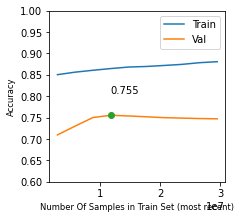

In [77]:
CM = 1 / 2.54

fig, ax = plt.subplots(figsize=(8*CM,8*CM))
# ax.plot(x,y)

ax.plot(train_sizes, train_acc, label = 'Train')
ax.plot(train_sizes, val_acc, label = 'Val')

plt.ylabel('Accuracy', fontsize = "small")
plt.xlabel('Number Of Samples in Train Set (most recent)', fontsize = "small")

xmax = train_sizes[np.argmax(val_acc)]
ymax = val_acc.max()
    # text= "x={:.3f}, y={:.3f}".format(xmax, ymax)
if not ax:
    ax=plt.gca()

# bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
# arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
# kw = dict(xycoords='data',textcoords="axes fraction",
# arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
# ax.annotate("*", xy=(xmax, ymax))#, xytext=(0.94,0.96),**kw)
ax.plot(xmax, ymax, 'o')
ax.text(xmax, ymax+0.05, f"{ymax:.3f}")
# title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
# plt.title(title, fontsize = 18, y = 1.03)
plt.legend(loc='upper right')
plt.ylim(0.6,1)
plt.show()

In [ ]:
        weight = np.geomspace(0.001, 1, num=len(y_train))
        # keep ordering of data
        timestamp = np.linspace(0, 1, len(y_train))

        # save to pool for faster memory access
        self._train_pool = Pool(
            data=x_train,
            label=y_train,
            cat_features=cat_features,
            weight=weight,
            timestamp=timestamp,
        )
        self._val_pool = Pool(data=x_val, label=y_val, cat_features=cat_features)
        self.name = name
        self._callbacks = CallbackContainer([SaveCallback()])

    def __call__(self, trial: optuna.Trial) -> float:
        """
        Perform a new search trial in Bayesian search.

        Hyperarameters are suggested, unless they are fixed.
        Args:
            trial (optuna.Trial): current trial.
        Returns:
            float: accuracy of trial on validation set.
        """
        # https://catboost.ai/en/docs/features/training-on-gpu
        gpu_count = get_gpu_device_count()
        task_type = "GPU" if gpu_count > 0 else "CPU"
        devices = f"0-{gpu_count-1}"

        # kaggle book + https://catboost.ai/en/docs/concepts/parameter-tuning
        # friedman paper
        learning_rate = trial.suggest_float("learning_rate", 0.001, 0.125, log=True)
        depth = trial.suggest_int("depth", 1, 12)
        l2_leaf_reg = trial.suggest_int("l2_leaf_reg", 2, 30)
        random_strength = trial.suggest_float("random_strength", 1e-9, 10.0, log=True)
        bagging_temperature = trial.suggest_float("bagging_temperature", 0.0, 1.0)
        kwargs_cat = {
            "iterations": 2000,
            "learning_rate": learning_rate,
            "depth": depth,
            "l2_leaf_reg": l2_leaf_reg,
            "random_strength": random_strength,
            "bagging_temperature": bagging_temperature,
            "grow_policy": "Lossguide",
            "border_count": 254,
            "logging_level": "Silent",
            "task_type": task_type,
            "devices": devices,
            "random_seed": set_seed(),
            "eval_metric": "Accuracy",
            "early_stopping_rounds": 100,
        }

        # callback only works for CPU, thus removed. See: https://bit.ly/3FjiuFx
        self._clf = CatBoostClassifier(**kwargs_cat)  # type: ignore
        self._clf.fit(
            self._train_pool,
            eval_set=self._val_pool,
            callbacks=None,
        )

In [ ]:
train = [1,2,3]

# go back from last element
for p in percentages:
    label.iloc[-len(train)*p:]



## Time consistency

Check if features maintain their predictive power over time, buy training on the first $10~\%$ of the training set and predicting the last $10~\%$ feature by feature. Remove features or further investigate features where accuracy is just above or below $0.5$. Technique found in this [notebook](https://www.kaggle.com/code/cdeotte/xgb-fraud-with-magic-0-9600/notebook).

In [4]:
data = pd.read_parquet(
    "gs://thesis-bucket-option-trade-classification/data/classical_size_features_log_normalized/train_set_extended_60.parquet",
    engine="fastparquet"
)

In [5]:
# try to predict last 10 % in training set using first 10 % of features. Accuracy should be above 50 %.
label = data["buy_sell"]
data.drop(columns=["buy_sell"], inplace=True)

In [6]:
y_train = label.iloc[0:len(label)//10]
y_test = label.iloc[-len(data)//10:]

X_train = data.iloc[0:len(data)//10,:]
X_test = data.iloc[-len(data)//10:,:]

del label, data

In [7]:
y_train.shape

(2951032,)

In [8]:
params = {
        "od_type": "Iter",
        "logging_level": "Silent",
        "loss_function": "Logloss",
        "task_type": "GPU",
        "cat_features": None,
        "random_seed": 42,
        "eval_metric":"Accuracy",
        "iterations":1000,
        "early_stopping_rounds":100,
}

In [13]:
columns = X_train.columns

In [21]:
results = []
for col in tqdm(columns):
  model = CatBoostClassifier(**params)
  model.fit(X_train[[col]], y_train, eval_set=(X_test[[col]],y_test))
  acc = model.score(X_test[[col]], y_test)
  results.append([col,acc])

  0%|          | 0/24 [00:00<?, ?it/s]

In [24]:
results_df = pd.DataFrame(results, columns=["feature", "accuracy"])
results_df.sort_values(by="accuracy")

,feature,accuracy
10,chg_ex_lag,0.518701
21,TRADE_SIZE,0.522728
9,chg_ex_lead,0.527728
12,chg_all_lag,0.547701
8,bid_ask_ratio_ex,0.548045
3,rel_ask_size_ex,0.550789
23,ask_size_ex,0.552150
19,price_ex_lag,0.552589
11,chg_all_lead,0.554612
0,TRADE_PRICE,0.554639


Few features are actually consistent over time and are more informative than a random guess. These include entire includes features related to the proximity of the quote and relative bid size.

Some features like `chg_ex_lead` are hard to exclude. Better weight observations, as suggested in `3.0c-feature-engineering.ipynb`.